In [1]:
from dynamicme.dynamic import DynamicME

/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/solvers/__init__.py:63: UserWarning: No LP solvers found
  warn("No LP solvers found")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/usr/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


## Load the built ME model

In [2]:
from cobrame.io.json import load_reduced_json_me_model, load_json_me_model
import pickle

In [3]:
with open('FoldME_Ali_keff.pickle','rb') as f:
    me = pickle.load(f)

In [ ]:
me.metabolites.get_by_id('ac_e')

# Set up the dynamic simulation

## Here, we will simulate the complex medium originally investigated by [Beg et al., 2007](http://www.pnas.org/content/104/31/12663)

### Metabolites to track

In [7]:
tracked_mets = [
    me.metabolites.ac_p,
    me.metabolites.gal_p,
    me.metabolites.glc__D_p,
    me.metabolites.glyc_p,
    me.metabolites.lac__L_p, 
    me.metabolites.malt_p
    ]
extra_rxns_tracked = [me.reactions.biomass_dilution, me.reactions.EX_o2_e]

### Also track translation fluxes

In [8]:
rxns_trsl = me.reactions.query('translation_')
print(len(rxns_trsl))
extra_rxns_tracked = extra_rxns_tracked + rxns_trsl

from cobrame.core.reaction import MetabolicReaction
import pandas as pd

rows_tracked = []

for met_track in tracked_mets:
    mid_c = met_track.id.replace('_p','_c')
    mid_e = met_track.id.replace('_p','_e')
    met_c = me.metabolites.get_by_id(mid_c)
    met_e = me.metabolites.get_by_id(mid_e)
    for rxn in met_track.reactions:
        if isinstance(rxn, MetabolicReaction) and rxn.keff and met_c in rxn.metabolites or met_e in rxn.metabolites:
            extra_rxns_tracked.append(rxn)
            rows_tracked.append({'met':met_track.id, 'rxn':rxn.id})
            #print met_track,'\t', rxn.id, '\t', rxn.keff          
            
df_tracked = pd.DataFrame(rows_tracked)

1579


In [9]:
dyme = DynamicME(me)

T = 10   # hours
V = 1.   # L
X0 = 0.00675 / V  # g/L
c0_dict = {'glc__D_e': 0.4,
           'lac__L_e': 0.4,
           'malt_e': 0.4,
           'gal_e': 0.4,
           'glyc_e':0.4,
           'ac_e': 0.0}
### Convert from g/L to mmol
for mid,c in c0_dict.items():
    met = me.metabolites.get_by_id(mid)
    c0_dict[met.id] = c / met.formula_weight * 1000

### Set max uptake rate
LB_EX = -10.
LB_O2 = -20.

lb_dict={}
ub_dict={}

for mid in c0_dict.keys():    
    rxn = dyme.get_exchange_rxn(mid)    
    if rxn.id == 'EX_o2_e':
        lb = LB_O2
    else:
        lb = LB_EX
    #rxn.lower_bound = lb
    lb_dict[rxn.id] = lb

#me.reactions.EX_o2_e.lower_bound = LB_O2
lb_dict[me.reactions.EX_o2_e.id] = LB_O2

print(c0_dict)
print(lb_dict)
print(ub_dict)

sim_params = {
    'T':T,
    'X0':X0,
    'c0_dict':c0_dict,
    'lb_dict':lb_dict,
    'ub_dict':ub_dict,
    'extra_rxns_tracked':extra_rxns_tracked,
    'ZERO_CONC':0.
}

{'glc__D_e': 2.220299442904667, 'lac__L_e': 4.4908498933423155, 'malt_e': 1.1685776026677226, 'gal_e': 2.220299442904667, 'glyc_e': 4.34339676647141, 'ac_e': 0.0}
{'EX_glc__D_e': -10.0, 'EX_lac__L_e': -10.0, 'EX_malt_e': -10.0, 'EX_gal_e': -10.0, 'EX_glyc_e': -10.0, 'EX_ac_e': -10.0, 'EX_o2_e': -20.0}
{}


In [33]:
import json

def convert_for_json(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_for_json(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_for_json(v) for v in obj]
    return obj

# ...after you get result...
json_result = convert_for_json(result)
with open('test_dynamicme_results.json', 'w') as f:
    json.dump(json_result, f)

# print(f"Results saved to {config.get('json_output_file', 'dynamicme_results.json')}")

In [12]:
biomass_rxn_ids = [r.id for r in me.reactions if r.id.endswith('_biomass_to_biomass')]
formation_rxn_ids = [r.id for r in me.reactions if r.id.startswith('formation_')]


In [13]:
for rxn_id in biomass_rxn_ids + formation_rxn_ids:
    rxn = me.reactions.get_by_id(rxn_id)
    
    extra_rxns_tracked += [rxn]

# Perform DynamicME simulation

In [14]:
dyme = DynamicME(me)

In [15]:
import time

tic = time.time()

result = dyme.simulate_batch(T = .1, # testing
                             c0_dict=c0_dict,
                             X0=X0, 
                             prec_bs=1e-3,
                             ZERO_CONC=0.,
                             extra_rxns_tracked=extra_rxns_tracked,
                             lb_dict={}, 
                             verbosity=1,
)   
toc = time.time()-tic

Metabolite glc__D_e available.
Using default LB=-1000 for EX_glc__D_e
Metabolite lac__L_e available.
Using default LB=-1000 for EX_lac__L_e
Metabolite malt_e available.
Using default LB=-1000 for EX_malt_e
Metabolite gal_e available.
Using default LB=-1000 for EX_gal_e
Metabolite glyc_e available.
Using default LB=-1000 for EX_glyc_e
Metabolite ac_e depleted.
Computing new uptake rates
Finished compiling expressions in 111.098186 seconds
Finished substituting S,lb,ub in 10.808743 seconds
Finished makeME_LP in 1.623027 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 10.621161 seconds
Finished makeME_LP in 1.616483 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 10.394697 seconds
Finished makeME_LP in 1.580271 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 10.298050 seconds
Finished makeME_LP in 1.709930 seconds
Getting MINOS parameters from ME_NLP...
Finished substituting S,lb,ub in 10.50

In [16]:
print('%g seconds'%toc)

1733.66 seconds


# Convert solution's metabolite concentrations from mM to g/L

In [17]:
from dynamicme.dynamic import ParamOpt

popt = ParamOpt(me, sim_params, growth_rxn=growth_rxn.id)
sol = popt.compute_conc_profile(result)

In [18]:
df_mw = pd.DataFrame([{'id':m.id,'mass':m.mass if hasattr(m,'mass') else m.formula_weight,'name':m.name} for m in me.metabolites])

sol_gL = sol.copy()
variables = c0_dict.keys()

for col in sol.columns:
    if col in variables:
        c_mM = sol[col]
        mw = df_mw[ df_mw.id==col].mass.values[0]
        c_gL = c_mM * mw / 1000.
        sol_gL[col] = c_gL
        
df_ex = pd.DataFrame(result['ex_flux'])

# Plot metabolite concentration profiles

/usr/lib/python3.6/site-packages/seaborn/axisgrid.py:337 UserWarning: The `size` parameter has been renamed to `height`; please update your code.


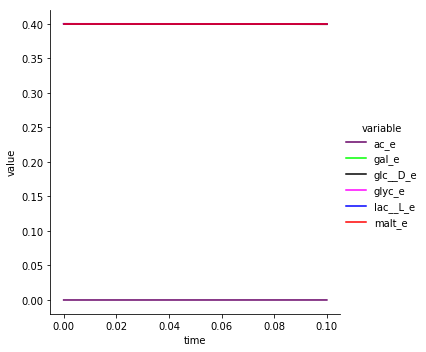

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

dsplot = sol_gL[[c for c in sol_gL.columns if c != 'biomass' and 'EX_' not in c]].melt(id_vars='time')

dsplot.variable.unique()

palette = ['#660066','#00FF00','#000000','#FF00FF','#0000FF','#FF0000']
sns.set_palette(palette)
g = sns.FacetGrid(dsplot, hue='variable', size=5)
g.map(plt.plot, 'time','value')
g.add_legend()

# Plot Mass Fractions

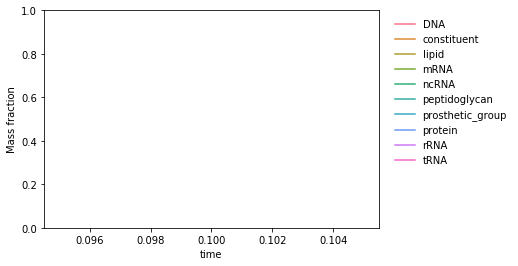

In [20]:
import numpy as np, pandas as pd

# figure out IDs from what's actually in your result
rf0 = result['rxn_flux'][0]
growth_rxn_id = 'biomass_dilution'  # change if yours differs
biomass_rxn_ids = sorted([k for k in rf0 if k.endswith('_biomass_to_biomass')])

rows = []
for t, rf in zip(result['time'], result['rxn_flux']):
    mu = rf.get(growth_rxn_id, np.nan)
    row = {'time': t, 'mu': mu}
    for rid in biomass_rxn_ids:
        pool = rid.replace('_biomass_to_biomass', '')   # e.g. 'protein','rRNA','DNA','lipid',...
        v = rf.get(rid, 0.0)
        row[pool] = (v / mu) if (mu and mu > 0) else np.nan
    rows.append(row)

df_mf = pd.DataFrame(rows).sort_values('time')
df_mf['sum_pools'] = df_mf.drop(columns=['time','mu']).sum(axis=1)  # ~1.0 sanity check
df_mf.head()
import seaborn as sns, matplotlib.pyplot as plt

value_cols = [c for c in df_mf.columns if c not in ('time','mu','sum_pools')]
df_long = df_mf.melt(id_vars='time', value_vars=value_cols,
                     var_name='pool', value_name='mass_fraction')

sns.lineplot(data=df_long, x='time', y='mass_fraction', hue='pool')
plt.ylabel('Mass fraction')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.show()


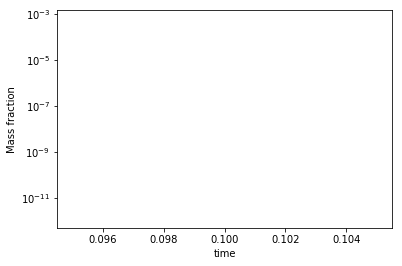

In [21]:
import numpy as np, pandas as pd

# figure out IDs from what's actually in your result
rf0 = result['rxn_flux'][0]
growth_rxn_id = 'biomass_dilution'  # change if yours differs
formation_rxn_ids = sorted([k for k in rf0 if 'formation' in  k])

rows = []
for t, rf in zip(result['time'], result['rxn_flux']):
    mu = rf.get(growth_rxn_id, np.nan)
    row = {'time': t, 'mu': mu}
    for rid in formation_rxn_ids:
        pool = rid.replace('formation_', '')   # e.g. 'protein','rRNA','DNA','lipid',...
        v = rf.get(rid, 0.0)
        row[pool] = (v / mu) if (mu and mu > 0) else np.nan
    rows.append(row)

df_mf = pd.DataFrame(rows).sort_values('time')
df_mf['sum_pools'] = df_mf.drop(columns=['time','mu']).sum(axis=1)  # ~1.0 sanity check
df_mf.head()
import seaborn as sns, matplotlib.pyplot as plt

value_cols = [c for c in df_mf.columns if c not in ('time','mu','sum_pools')]
df_long = df_mf.melt(id_vars='time', value_vars=value_cols,
                     var_name='pool', value_name='mass_fraction')

fig, ax = plt.subplots()

ax = sns.lineplot(data=df_long, x='time', y='mass_fraction', hue='pool',legend=False)
ax.set_ylabel('Mass fraction')
# plt.ylim(0, 1)
ax.set_yscale('log')
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.show()
